# Preprocess

In [66]:
import pandas as pd
import numpy as np

### Read the csv file.

In [67]:
orders_df = pd.read_csv("data/archive/olist_orders_dataset.csv")
customers_df = pd.read_csv("data/archive/olist_customers_dataset.csv")
geolocation_df = pd.read_csv("data/archive/olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("data/archive/olist_order_items_dataset.csv")
products_df = pd.read_csv("data/archive/olist_products_dataset.csv")
sellers_df = pd.read_csv("data/archive/olist_sellers_dataset.csv")

### Get the label column by comparing df['order_estimated_delivery_date'] and  df['order_delivered_customer_date']

In [68]:
orders_df.order_purchase_timestamp = pd.to_datetime(pd.to_datetime(orders_df.order_purchase_timestamp, format='%Y-%m-%d %H:%M:%S').dt.date)
orders_df.order_approved_at = pd.to_datetime(pd.to_datetime(orders_df.order_approved_at, format='%Y-%m-%d %H:%M:%S').dt.date)
orders_df.order_delivered_carrier_date = pd.to_datetime(pd.to_datetime(orders_df.order_delivered_carrier_date, format='%Y-%m-%d %H:%M:%S').dt.date)
orders_df.order_delivered_customer_date = pd.to_datetime(pd.to_datetime(orders_df.order_delivered_customer_date, format='%Y-%m-%d %H:%M:%S').dt.date)
orders_df.order_estimated_delivery_date = pd.to_datetime(pd.to_datetime(orders_df.order_estimated_delivery_date, format='%Y-%m-%d %H:%M:%S').dt.date)

In [69]:
orders_df = orders_df[orders_df['order_status'] == 'delivered']
orders_df.drop('order_status', axis=1, inplace=True)
orders_df['anomaly'] = orders_df['order_estimated_delivery_date'] < orders_df['order_delivered_customer_date']

### Enforce a rule: order_purchase_timestamp <= order_approved_at <= order_delivered_carrier_date <= order_delivered_customer_date

In [70]:
orders_df = orders_df[orders_df['order_purchase_timestamp'] <= orders_df['order_approved_at']]
orders_df = orders_df[orders_df['order_approved_at'] <= orders_df['order_delivered_carrier_date']]
orders_df = orders_df[orders_df['order_delivered_carrier_date'] <= orders_df['order_delivered_customer_date']]

Time to approve an order and to deliver an order to a carrier influences delivery time.

In [71]:
orders_df['time_estimate_delivery'] = (orders_df['order_estimated_delivery_date'] - orders_df['order_delivered_carrier_date']).dt.days

In [72]:
orders_df['year'] = orders_df['order_purchase_timestamp'].dt.year
orders_df['month'] = orders_df['order_purchase_timestamp'].dt.month
orders_df['day'] = orders_df['order_purchase_timestamp'].dt.day

In [73]:
orders_df.drop(['order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1, inplace=True)

In [74]:
orders_df['anomaly'].sum() / orders_df.shape[0]

0.06807573020331868

About 6.8% of the records are anomalies.

### Preprocess the customers dataset.

In [75]:
customers_df.drop(['customer_unique_id', 'customer_city', 'customer_state'], axis=1, inplace=True)

### Preprocess the sellers dataset.

In [76]:
sellers_df.drop(['seller_city', 'seller_state'], axis=1, inplace=True)
sellers_df.head()

,seller_id,seller_zip_code_prefix
0,3442f8959a84dea7ee197c632cb2df15,13023
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195
4,51a04a8a6bdcb23deccc82b0b80742cf,12914


### Preprocess the geolocation dataset.

In [77]:
geolocation_df.drop(['geolocation_city', 'geolocation_state'], axis=1, inplace=True)
geolocation_df = geolocation_df.groupby(['geolocation_zip_code_prefix']).mean()

In [78]:
geolocation_df.head()

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
1001,-23.550190,-46.634024
1002,-23.548146,-46.634979
1003,-23.548994,-46.635731
1004,-23.549799,-46.634757
1005,-23.549456,-46.636733


### Merge customers and sellers data with geolocation information.

In [79]:
customers_geolocation_df = pd.merge(customers_df, geolocation_df, how="left", left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
customers_geolocation_df.dropna(inplace=True)
customers_geolocation_df.rename(columns={"geolocation_lat": "customer_geolocation_lat", "geolocation_lng": "customer_geolocation_lng"}, inplace=True)

In [80]:
customers_geolocation_df.head()

,customer_id,customer_zip_code_prefix,customer_geolocation_lat,customer_geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,9790,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,1151,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,8775,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056,-22.975100,-47.142925


In [81]:
sellers_geolocation_df = pd.merge(sellers_df, geolocation_df, how="left", left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
sellers_geolocation_df.dropna(inplace=True)
sellers_geolocation_df.rename(columns={"geolocation_lat": "seller_geolocation_lat", "geolocation_lng": "seller_geolocation_lng"}, inplace=True)

In [82]:
sellers_geolocation_df.head()

,seller_id,seller_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,-22.383437,-46.947927
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,-22.909572,-43.177703
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,-23.657242,-46.612831
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,-22.964803,-46.534419


### Preprocess products data

In [83]:
products_df.drop(['product_name_lenght', 'product_description_lenght', 'product_photos_qty'], axis=1, inplace=True)
products_df.product_category_name = products_df.product_category_name.astype(str)
products_df.dropna(inplace=True)

In [84]:
products_df.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0


### Merge order items data with sellers and product information

In [85]:
order_items_df.shipping_limit_date = pd.to_datetime(pd.to_datetime(order_items_df.shipping_limit_date, format='%Y-%m-%d %H:%M:%S').dt.date)
order_items_sellers_geolocation_df = pd.merge(order_items_df, sellers_geolocation_df, how='left', on='seller_id')
order_items_sellers_geolocation_df.dropna(inplace=True)
order_items_sellers_geolocation_products_df = pd.merge(order_items_sellers_geolocation_df, products_df, how='left', on='product_id')
order_items_sellers_geolocation_products_df.dropna(inplace=True)

In [86]:
order_items_sellers_geolocation_products_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19,58.90,13.29,27277.0,-22.496953,-44.127492,cool_stuff,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03,239.90,19.93,3471.0,-23.565096,-46.518565,pet_shop,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18,199.00,17.87,37564.0,-22.262584,-46.171124,moveis_decoracao,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15,12.99,12.79,14403.0,-20.553624,-47.387359,perfumaria,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13,199.90,18.14,87900.0,-22.929384,-53.135873,ferramentas_jardim,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112392,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02,299.99,43.41,88303.0,-26.912574,-48.673980,utilidades_domesticas,10150.0,89.0,15.0,40.0
112393,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20,350.00,36.53,1206.0,-23.535864,-46.642819,informatica_acessorios,8950.0,45.0,26.0,38.0
112394,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30,99.90,16.95,80610.0,-25.469955,-49.289821,esporte_lazer,967.0,21.0,24.0,19.0
112395,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21,55.99,8.72,4733.0,-23.635530,-46.694031,informatica_acessorios,100.0,20.0,20.0,20.0


### Merge orders with order items and customers_geolocation

In [87]:
orders_order_items_sellers_geolocation_products_df = pd.merge(orders_df, order_items_sellers_geolocation_products_df, how='left', on='order_id')
df = pd.merge(orders_order_items_sellers_geolocation_products_df, customers_geolocation_df, how='left', on='customer_id')
df.dropna(inplace=True)

In [88]:
df = df[df.shipping_limit_date >= df.order_delivered_carrier_date]

In [89]:
df.drop(['order_id', 'customer_id', 'order_purchase_timestamp', 'order_delivered_carrier_date', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date'], axis=1, inplace=True)

In [90]:
df.isnull().values.any()

False

In [91]:
df['anomaly'].sum() / df.shape[0]

0.05381306218224482

Percentage of anomalies remains to be around 6.6%.

In [92]:
def haversine(customer_lng, customer_lat, seller_lng, seller_lat):
    lon1, lat1, lon2, lat2 = map(np.radians, [customer_lng, customer_lat, seller_lng, seller_lat])

    lon = seller_lng - customer_lng
    lat = seller_lat - customer_lat

    r = np.sin(lat / 2.0) ** 2 + np.cos(customer_lat) * np.cos(seller_lat) * np.sin(lon / 2.0) ** 2

    distance = 6371 * 2 * np.arcsin(np.sqrt(r))
    return distance

df['distance'] = haversine(df['customer_geolocation_lng'], df['customer_geolocation_lat'], df['seller_geolocation_lng'], df['seller_geolocation_lat'])

In [93]:
df.dtypes

anomaly                        bool
time_estimate_delivery        int64
year                          int32
month                         int32
day                           int32
price                       float64
freight_value               float64
seller_zip_code_prefix      float64
seller_geolocation_lat      float64
seller_geolocation_lng      float64
product_category_name        object
product_weight_g            float64
product_length_cm           float64
product_height_cm           float64
product_width_cm            float64
customer_zip_code_prefix    float64
customer_geolocation_lat    float64
customer_geolocation_lng    float64
distance                    float64
dtype: object

In [94]:
df.anomaly.value_counts()

anomaly
False    96776
True      5504
Name: count, dtype: int64

In [95]:
df.columns[df.isnull().any()].tolist()

[]

# Supervised

In [62]:
X = df.drop(['anomaly'], axis=1)
y = df['anomaly']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
X[['product_category_name']] = encoder.fit_transform(X[['product_category_name']])

# split X y to train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from sklearn.utils import resample, shuffle

df_train = pd.concat([X_train, y_train], axis=1)
df_train_True = df_train[df_train.anomaly]
df_train_False = df_train[df_train.anomaly==False]

df_train_False = resample(df_train_False, replace=True, n_samples=df_train_True.shape[0])

df_train_balanced = shuffle(pd.concat([df_train_True, df_train_False]))
X_train = df_train_balanced.drop(['anomaly'], axis=1)
y_train = df_train_balanced['anomaly']

### XGBoost

In [63]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
y_predict = XGB.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
print('confusion matrix:', confusion_matrix(y_test, y_predict))
print('accuracy:', accuracy_score(y_test, y_predict))
print('precision:', precision_score(y_test, y_predict))
print('recall:', recall_score(y_test, y_predict))

confusion matrix: [[21927  7088]
 [  347  1322]]
accuracy: 0.7576913049146135
precision: 0.1571938168846611
recall: 0.7920910724985021


### Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

LR = LogisticRegression()
LR.fit(X_train, y_train)
y_predict = LR.predict(X_test)

print('confusion matrix:', confusion_matrix(y_test, y_predict))
print('accuracy:', accuracy_score(y_test, y_predict))
print('precision:', precision_score(y_test, y_predict))
print('recall:', recall_score(y_test, y_predict))

confusion matrix: [[20080  8935]
 [  754   915]]
accuracy: 0.6842328249250423
precision: 0.09289340101522843
recall: 0.54823247453565


/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_predict = RF.predict(X_test)

print('confusion matrix:', confusion_matrix(y_test, y_predict))
print('accuracy:', accuracy_score(y_test, y_predict))
print('precision:', precision_score(y_test, y_predict))
print('recall:', recall_score(y_test, y_predict))

confusion matrix: [[22703  6333]
 [  409  1239]]
accuracy: 0.7802763655325251
precision: 0.16362916006339145
recall: 0.7518203883495146


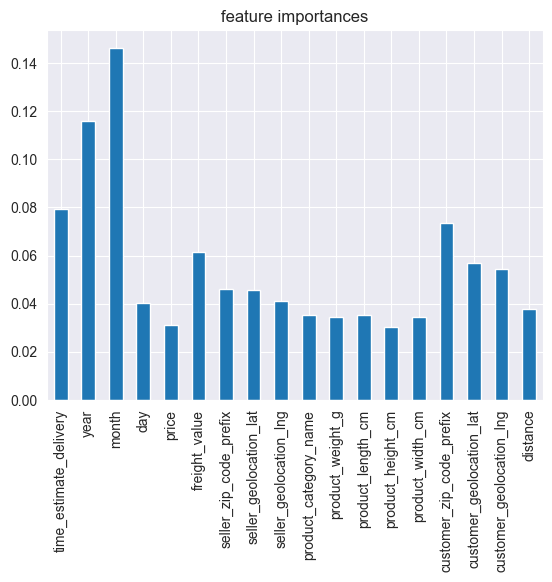

In [34]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(XGB.feature_importances_, index = X.columns)

feature_importances_plot = feature_importances.plot(kind='bar', title='feature importances')
fig = feature_importances_plot.get_figure()
plt.show()

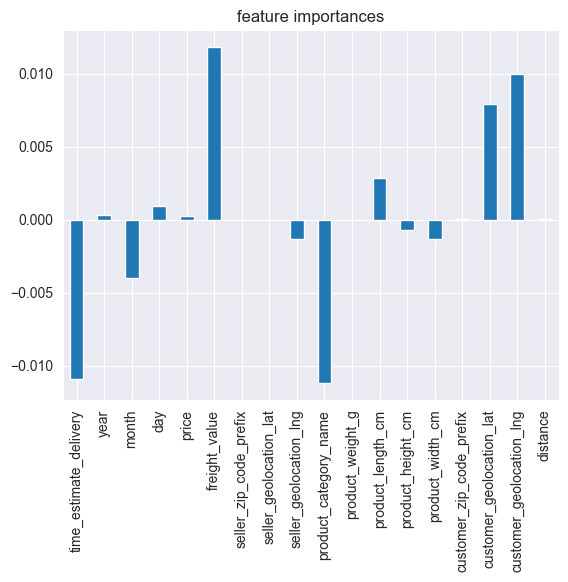

In [35]:
feature_importances = pd.Series(LR.coef_[0], index = X.columns)

feature_importances_plot = feature_importances.plot(kind='bar', title='feature importances')
fig = feature_importances_plot.get_figure()
plt.show()

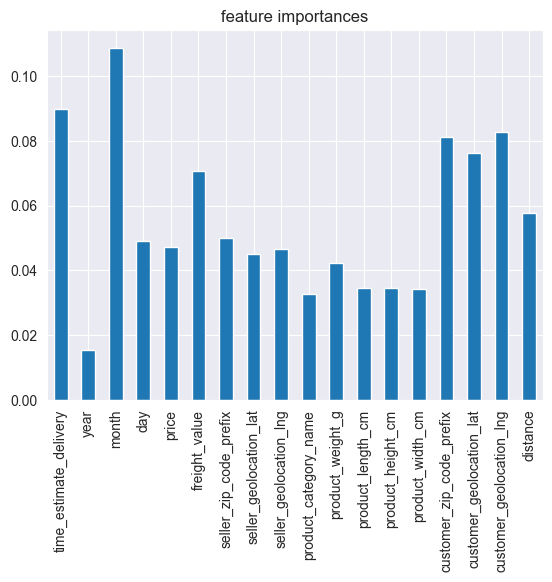

In [36]:
feature_importances = pd.Series(RF.feature_importances_, index = X.columns)

feature_importances_plot = feature_importances.plot(kind='bar', title='feature importances')
fig = feature_importances_plot.get_figure()
plt.show()

In [37]:
print(X.columns)

Index(['time_estimate_delivery', 'year', 'month', 'day', 'price',
       'freight_value', 'seller_zip_code_prefix', 'seller_geolocation_lat',
       'seller_geolocation_lng', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_zip_code_prefix', 'customer_geolocation_lat',
       'customer_geolocation_lng', 'distance'],
      dtype='object')


In [38]:
columns1 = ['time_estimate_delivery', 'year', 'month', 'day', 'freight_value', 'seller_zip_code_prefix', 'seller_geolocation_lat', 'seller_geolocation_lng','customer_zip_code_prefix', 'customer_geolocation_lat', 'customer_geolocation_lng', 'distance']

In [39]:
X1_train = X_train[columns1]
X1_test = X_test[columns1]

confusion matrix: [[22462  6574]
 [  385  1263]]
accuracy: 0.7732042758440881
precision: 0.16115860660967207
recall: 0.7663834951456311


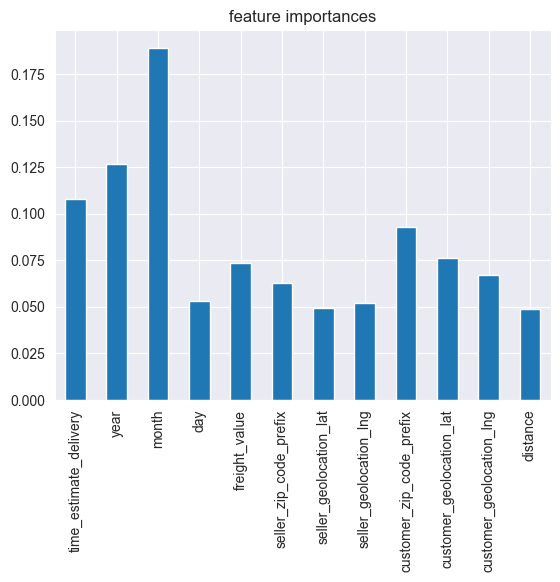

In [40]:
XGB = XGBClassifier()
XGB.fit(X1_train, y_train)
y_predict = XGB.predict(X1_test)

print('confusion matrix:', confusion_matrix(y_test, y_predict))
print('accuracy:', accuracy_score(y_test, y_predict))
print('precision:', precision_score(y_test, y_predict))
print('recall:', recall_score(y_test, y_predict))

feature_importances = pd.Series(XGB.feature_importances_, index = columns1)

feature_importances_plot = feature_importances.plot(kind='bar', title='feature importances')
fig = feature_importances_plot.get_figure()
plt.show()

confusion matrix: [[18844 10192]
 [  626  1022]]
accuracy: 0.647438404380133
precision: 0.09113607990012484
recall: 0.6201456310679612


/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


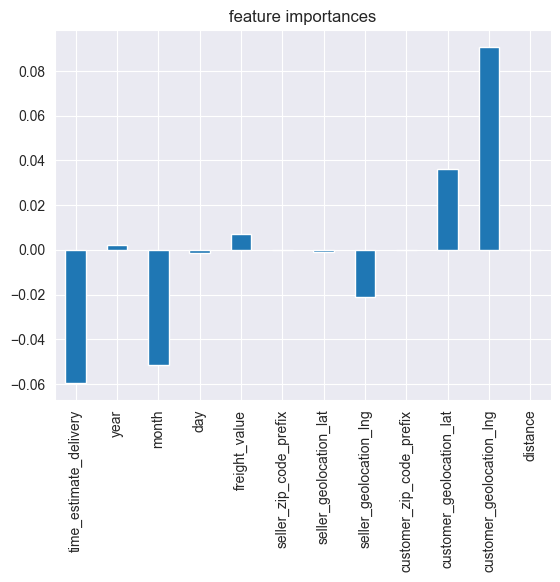

In [41]:
LR = LogisticRegression()
LR.fit(X1_train, y_train)
y_predict = LR.predict(X1_test)

print('confusion matrix:', confusion_matrix(y_test, y_predict))
print('accuracy:', accuracy_score(y_test, y_predict))
print('precision:', precision_score(y_test, y_predict))
print('recall:', recall_score(y_test, y_predict))

feature_importances = pd.Series(LR.coef_[0], index = columns1)

feature_importances_plot = feature_importances.plot(kind='bar', title='feature importances')
fig = feature_importances_plot.get_figure()
plt.show()

confusion matrix: [[22966  6070]
 [  425  1223]]
accuracy: 0.7883261634728197
precision: 0.16769505004799123
recall: 0.7421116504854369


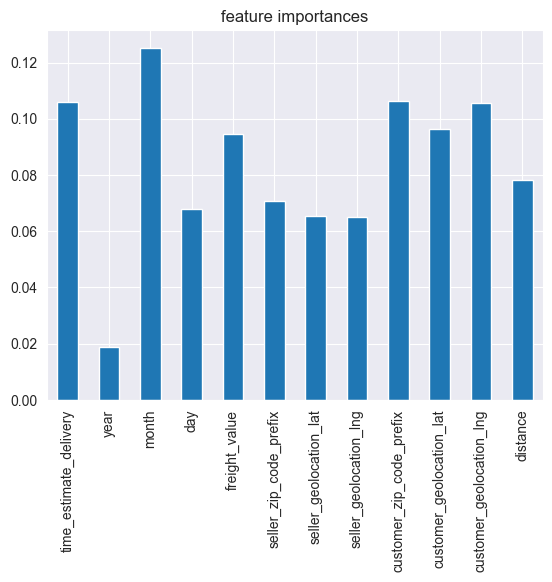

In [42]:
RF = RandomForestClassifier()
RF.fit(X1_train, y_train)
y_predict = RF.predict(X1_test)

print('confusion matrix:', confusion_matrix(y_test, y_predict))
print('accuracy:', accuracy_score(y_test, y_predict))
print('precision:', precision_score(y_test, y_predict))
print('recall:', recall_score(y_test, y_predict))

feature_importances = pd.Series(RF.feature_importances_, index = columns1)

feature_importances_plot = feature_importances.plot(kind='bar', title='feature importances')
fig = feature_importances_plot.get_figure()
plt.show()

By analyzing feature importances and trying, I find the features which are important

• time_estimate_delivery
• distance
• freight_value

• year
• month
• day

• seller_zip_code_prefix
• seller_geolocation_lat
• seller_geolocation_lng
• customer_zip_code_prefix
• customer_geolocation_lat
• customer_geolocation_lng

The low precision value is because the test dataset is imbalanced while the train dataset is balanced by me. However, if not using balanced dataset, the recall rate is low. I think recall is more important than precision.

# Unsupervised

### Preprocess the dataset for clustering

Create a balanced dataset.

In [43]:
df_True = df[df.anomaly]
df_False = df[df.anomaly==False]

df_False = resample(df_False, replace=True, n_samples=df_True.shape[0])

df_balanced = shuffle(pd.concat([df_True, df_False]))
df_balanced.reset_index(drop=True, inplace=True)
X_balanced = df_balanced.drop(['anomaly'], axis=1)
y_balanced = df_balanced['anomaly']

Using only selected features

In [44]:
X_balanced = pd.DataFrame(X_balanced[columns1])
X = pd.DataFrame(X[columns1])

Transform the features to follow a normal distribution

In [45]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X_balanced = pd.DataFrame(qt.fit_transform(X_balanced), columns=columns1)
X = pd.DataFrame(qt.fit_transform(X), columns=columns1)

In [49]:
X

,time_estimate_delivery,year,month,day,freight_value,seller_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng,customer_zip_code_prefix,customer_geolocation_lat,customer_geolocation_lng,distance
0,-0.920412,-0.758004,1.016672,-1.659093,-1.307063,-0.411534,-0.967422,0.866189,-1.727428,-0.648586,0.085789,-1.430600
1,-0.429351,5.199338,0.307111,0.759677,0.810661,0.758004,1.684464,1.358913,0.569502,1.369978,0.471365,0.137889
2,0.739737,5.199338,0.595437,-0.687939,0.516485,0.156199,0.955471,-0.587964,0.933438,0.991512,-0.756400,0.292515
3,0.300542,-0.758004,1.312981,0.191865,1.103461,0.769761,1.649237,1.475269,0.680177,1.812669,2.136955,1.018518
4,-1.161976,5.199338,-1.169401,-0.241963,-1.307063,-0.497809,-0.370902,1.035790,-0.766037,-0.910895,0.203379,-1.310870
...,...,...,...,...,...,...,...,...,...,...,...,...
102275,0.300542,5.199338,-1.169401,-0.922330,0.618283,0.489307,0.625137,-1.475269,-0.632098,-1.099297,0.260089,0.045511
102276,1.109378,-0.758004,0.595437,1.194628,2.100262,-0.549574,-0.447305,0.854624,0.553133,0.956103,1.515500,-0.592435
102277,1.467860,5.199338,-5.199338,-0.687939,1.565654,0.868016,1.125776,1.164444,0.124629,0.278068,1.149613,1.342177
102278,1.467860,5.199338,-5.199338,-0.687939,1.565654,0.868016,1.125776,1.164444,0.124629,0.278068,1.149613,1.342177


### Visualization of clustering after PCA

unbalanced

<Axes: xlabel='x', ylabel='y'>

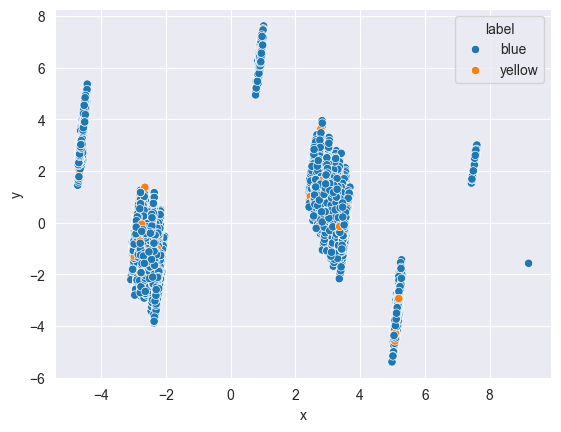

In [50]:
from sklearn.decomposition import  PCA

pca = PCA(n_components=2)
pct = pca.fit_transform(X)

colors = ['yellow' if elem else 'blue' for elem in y]

data = pd.concat([pd.DataFrame(pct), pd.DataFrame(colors)], axis=1)

data.columns = ['x', 'y', 'label']

import seaborn as sns

sns.scatterplot(data=data, x="x", y="y", hue="label")

balanced

<Axes: xlabel='x', ylabel='y'>

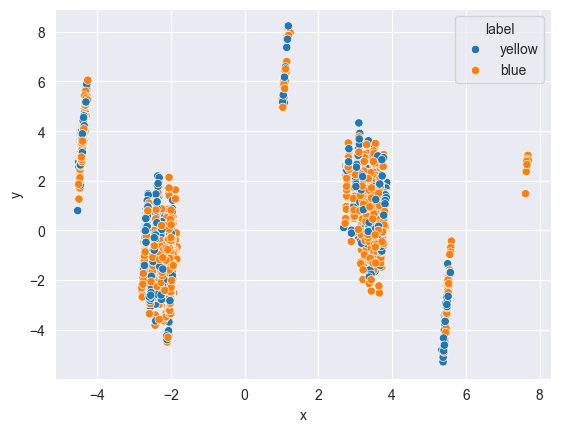

In [51]:
from sklearn.decomposition import  PCA

pca_balanced = PCA(n_components=2)
pct_balanced = pca_balanced.fit_transform(X_balanced)

colors_balanced = ['yellow' if elem else 'blue' for elem in y_balanced]

data_balanced = pd.concat([pd.DataFrame(pct_balanced), pd.DataFrame(colors_balanced)], axis=1)

data_balanced.columns = ['x', 'y', 'label']

sns.scatterplot(data=data_balanced, x="x", y="y", hue="label")

### KMeans

#### Unbalanced KMeans

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

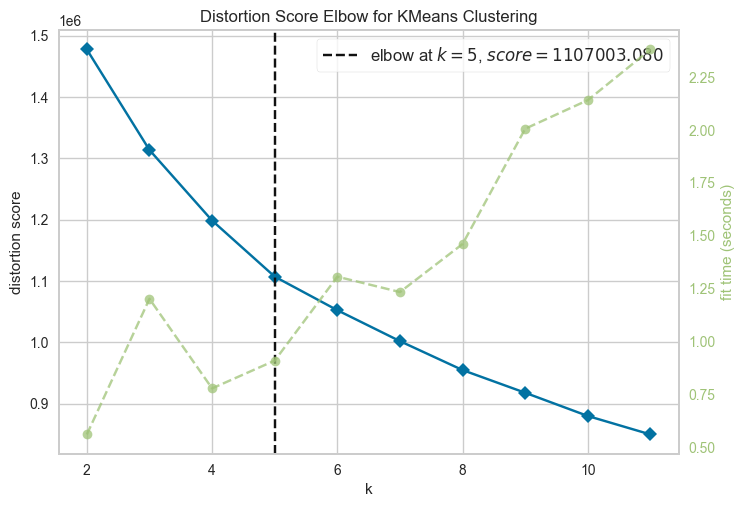

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The optimal number of clusters is 5.

In [53]:
k_means = KMeans(init="k-means++", n_clusters=5, n_init=10)
k_means.fit(X)

from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

from sklearn.metrics.pairwise import pairwise_distances_argmin_min

k_means_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, k_means_cluster_centers)).T
k_means_distances_df.columns = ['cluster', 'distance']

k_means_distances_df = pd.concat([k_means_distances_df, y], axis=1)
k_means_distances_df.groupby(['cluster', 'anomaly']).mean()

distance
cluster anomaly          
0.0     False    2.510670
        True     2.493789
1.0     False    3.060245
        True     3.051738
2.0     False    3.198685
        True     3.225167
3.0     False    3.438137
        True     3.445700
4.0     False    3.192853
        True     3.171065

In [54]:
k_means_distances_df.groupby(['cluster', 'anomaly']).count()

distance
cluster anomaly          
0.0     False       14162
        True          800
1.0     False        5097
        True          281
2.0     False       28892
        True         1631
3.0     False        7169
        True          434
4.0     False       35203
        True         2012

Kmeans doesn't provide any useful information.

#### Balanced KMeans

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

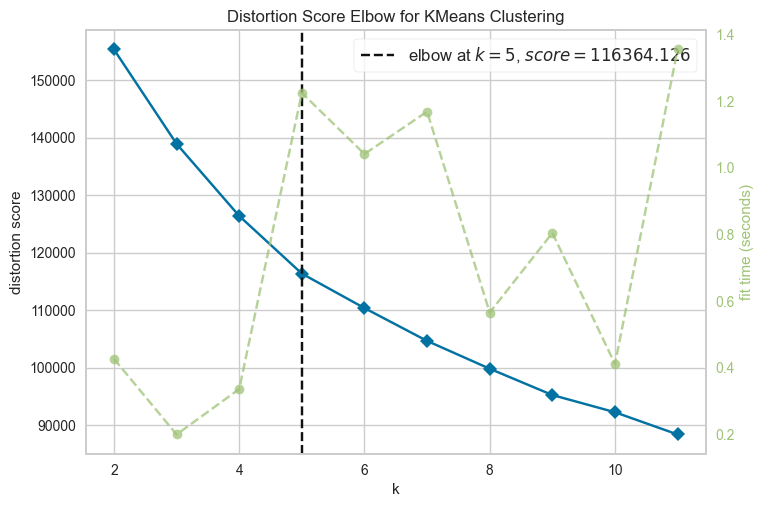

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model_balanced = KMeans()
visualizer_balanced = KElbowVisualizer(model_balanced, k=(2, 12))

visualizer_balanced.fit(X_balanced)        # Fit the data to the visualizer
visualizer_balanced.show()        # Finalize and render the figure

In [56]:
k_means_balanced = KMeans(init="k-means++", n_clusters=5, n_init=10)
k_means_balanced.fit(X_balanced)

k_means_cluster_centers_balanced = k_means_balanced.cluster_centers_

k_means_labels_balanced = pairwise_distances_argmin(X_balanced, k_means_cluster_centers_balanced)

k_means_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, k_means_cluster_centers_balanced)).T
k_means_distances_df_balanced.columns = ['cluster', 'distance']
k_means_distances_df_balanced = pd.concat([k_means_distances_df_balanced, y_balanced], axis=1)
k_means_distances_df_balanced.groupby(['cluster', 'anomaly']).mean()

distance
cluster anomaly          
0.0     False    3.523941
        True     3.357307
1.0     False    3.286534
        True     2.964347
2.0     False    3.227315
        True     3.103393
3.0     False    2.606645
        True     2.545354
4.0     False    3.247581
        True     2.839570

In [57]:
k_means_distances_df_balanced.groupby(['cluster', 'anomaly']).count()

distance
cluster anomaly          
0.0     False         452
        True          339
1.0     False        1577
        True         2413
2.0     False        2138
        True         1622
3.0     False        1025
        True          788
4.0     False         312
        True          342

### Affinity Propagation

#### Unbalanced

Trying the algorithm on unbalanced dataset is computationally impossible and meaningless.

In [58]:
'''
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
len(cluster_centers_indices)
'''

'\nfrom sklearn.cluster import AffinityPropagation\n\naf = AffinityPropagation(random_state=0).fit(X)\ncluster_centers_indices = af.cluster_centers_indices_\nlabels = af.labels_\nlen(cluster_centers_indices)\n'

#### Balanced

In [60]:
from sklearn.cluster import AffinityPropagation

pca = PCA(n_components=5)
pct_balanced = pca.fit_transform(X_balanced)
af_balanced = AffinityPropagation(random_state=0).fit(pct_balanced)
cluster_centers_indices_balanced = af_balanced.cluster_centers_indices_
labels_balanced = af_balanced.labels_
len(cluster_centers_indices_balanced)

143

### Mean shift

#### Unbalanced

In [83]:
'''
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
'''

'\nfrom sklearn.cluster import MeanShift, estimate_bandwidth\n\nbandwidth = estimate_bandwidth(X, quantile=0.3)\n\nms = MeanShift(bandwidth=bandwidth, bin_seeding=True)\nms.fit(X)\nlabels = ms.labels_\ncluster_centers = ms.cluster_centers_\n'

In [ ]:
'''
mean_shift_distances_df = pd.DataFrame(pairwise_distances_argmin_min(X, cluster_centers)).T
mean_shift_distances_df.columns = ['cluster', 'distance']
mean_shift_distances_df = pd.concat([mean_shift_distances_df, y], axis=1)
mean_shift_distances_df.groupby(['cluster', 'ontime']).mean()
'''

In [ ]:
# mean_shift_distances_df.groupby(['cluster', 'ontime']).count()

#### Balanced

In [62]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth_balanced = estimate_bandwidth(X_balanced, quantile=0.3)

ms_balanced = MeanShift(bandwidth=bandwidth_balanced, bin_seeding=True)
ms_balanced.fit(X_balanced)
labels_balanced = ms_balanced.labels_
cluster_centers_balanced = ms_balanced.cluster_centers_

In [64]:
mean_shift_distances_df_balanced = pd.DataFrame(pairwise_distances_argmin_min(X_balanced, cluster_centers_balanced)).T
mean_shift_distances_df_balanced.columns = ['cluster', 'distance']
mean_shift_distances_df_balanced = pd.concat([mean_shift_distances_df_balanced, y_balanced], axis=1)
mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).mean()

distance
cluster anomaly          
0.0     False    3.712634
        True     3.334037
1.0     False    3.600907
        True     3.519791

In [65]:
mean_shift_distances_df_balanced.groupby(['cluster', 'anomaly']).count()

distance
cluster anomaly          
0.0     False        3018
        True         3522
1.0     False        2486
        True         1982

### Hierarchical clustering

#### Unbalanced

In [ ]:
'''
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering = AgglomerativeClustering(n_clusters=5).fit(X)
'''

In [ ]:
'''
hierarchical_clustering_labels_df = pd.DataFrame(hierarchical_clustering.labels_, columns=['cluster'])
hierarchical_clustering_labels_df = pd.concat([hierarchical_clustering_labels_df, y], axis=1)
pd.DataFrame(hierarchical_clustering_labels_df.value_counts())
'''

#### Balanced

In [47]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering_balanced = AgglomerativeClustering(n_clusters=5).fit(X_balanced)

In [48]:
hierarchical_clustering_labels_df_balanced = pd.DataFrame(hierarchical_clustering_balanced.labels_, columns=['cluster'])
hierarchical_clustering_labels_df_balanced = pd.concat([hierarchical_clustering_labels_df_balanced, y_balanced], axis=1)
hierarchical_clustering_labels_df_balanced.value_counts()

cluster  anomaly
0        True       3114
         False      2591
1        False      2047
         True       1591
2        False       424
3        True        313
2        True        312
3        False       277
4        True        174
         False       165
Name: count, dtype: int64

### HDBSCAN

#### Unbalanced

In [49]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(X)

HDBSCAN(min_cluster_size=20)

In [50]:
hdbscan_labels_df = pd.DataFrame(hdb.labels_, columns=['clusters'])
hdbscan_labels_df = pd.concat([hdbscan_labels_df, y], axis=1)
hdbscan_labels_df[hdbscan_labels_df.clusters==-1].value_counts()

clusters  anomaly
-1.0      False      28180
          True        1610
Name: count, dtype: int64

#### Balanced

In [51]:
from sklearn.cluster import HDBSCAN

hdb_balanced = HDBSCAN(min_cluster_size=20)
hdb_balanced.fit(X_balanced)

HDBSCAN(min_cluster_size=20)

In [52]:
hdbscan_labels_df_balanced = pd.DataFrame(hdb_balanced.labels_, columns=['clusters'])
hdbscan_labels_df_balanced = pd.concat([hdbscan_labels_df_balanced, y_balanced], axis=1)
hdbscan_labels_df_balanced[hdbscan_labels_df_balanced.clusters==-1].value_counts()

clusters  anomaly
-1        False      1977
          True       1417
Name: count, dtype: int64

### OPTICS

#### Unbalanced

In [53]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=2).fit(X)

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [54]:
optics_labels_df = pd.DataFrame(optics.labels_, columns=['clusters'])
optics_labels_df = pd.concat([optics_labels_df, y], axis=1)
optics_labels_df[optics_labels_df.clusters==-1].value_counts()

clusters  anomaly
-1.0      False      35062
          True        2030
Name: count, dtype: int64

#### Balanced

In [55]:
from sklearn.cluster import OPTICS

optics_balanced = OPTICS(min_samples=2).fit(X_balanced)

/Users/boweigao/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [56]:
optics_labels_df_balanced = pd.DataFrame(optics_balanced.labels_, columns=['clusters'])
optics_labels_df_balanced = pd.concat([optics_labels_df_balanced, y_balanced], axis=1)
optics_labels_df_balanced[optics_labels_df_balanced.clusters==-1].value_counts()

clusters  anomaly
-1        False      2549
          True       2203
Name: count, dtype: int64

### BIRCH

#### Unbalanced

In [57]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=5)
brc.fit(X)
brc.predict(X)

array([1, 0, 0, ..., 2, 2, 0])

In [58]:
brc_labels_df = pd.DataFrame(brc.labels_, columns=['clusters'])
brc_labels_df = pd.concat([brc_labels_df, y], axis=1)
brc_labels_df.value_counts()

clusters  anomaly
0.0       False      42505
1.0       False      33583
2.0       False       6862
4.0       False       4786
3.0       False       2787
0.0       True        2385
1.0       True        1930
2.0       True         420
4.0       True         265
3.0       True         158
Name: count, dtype: int64

#### Balanced

In [59]:
from sklearn.cluster import Birch

brc_balanced = Birch(n_clusters=5)
brc_balanced.fit(X_balanced)
brc_balanced.predict(X_balanced)

array([1, 1, 1, ..., 1, 0, 0])

In [60]:
brc_labels_df_balanced = pd.DataFrame(brc_balanced.labels_, columns=['clusters'])
brc_labels_df_balanced = pd.concat([brc_labels_df_balanced, y_balanced], axis=1)
brc_labels_df_balanced.value_counts()

clusters  anomaly
0         True       3114
          False      2590
1         False      2047
          True       1591
2         False       425
4         True        313
2         True        312
4         False       277
3         True        174
          False       165
Name: count, dtype: int64

### Spectral clustering

#### balanced

In [46]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=0).fit(X_balanced)

KeyboardInterrupt: 